In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import collections
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import trange
from tqdm.notebook import tqdm
import gc
import nltk
from nltk import word_tokenize
from nltk.probability import DictionaryProbDist, FreqDist
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.extmath import randomized_svd

In [ ]:
ft = dict()
with open("/home/piotr/nlp/cc.pl.300.vec","r") as f:
    next(f)
    for line in tqdm(f):
        elem = line.split()
        ft[elem[0]] = np.array(elem[1:])

In [ ]:
ft["idę"]
ft["pójdzie"]
ft["idą"]
ft["iść"]

In [2]:
date = pd.Period('2020-03-20', 'D') 
tweet_data = pd.DataFrame()

for _ in trange(30):
    date += 1
    datestr = date.strftime("%Y_%m_%d")
    
    path = "data/clean/gov_tweets_" + datestr + ".csv"
    gov_data = pd.read_csv(path, header = 0, index_col = False, dtype = str)
    gov_data["source"] = "government"
    gov_data = gov_data.loc[gov_data.created_at.notna()]
    #gov_data = gov_data.drop(columns = ["index"])


    path = "data/clean/opp_tweets_" + datestr + ".csv"
    opp_data = pd.read_csv(path, header = 0, index_col = False, dtype = str)
    opp_data["source"] = "opposition"
    opp_data = opp_data.loc[opp_data.created_at.notna()]
    #opp_data = opp_data.drop(columns = ["index"])

    #merge the datasets
    tweet_data = tweet_data.append(gov_data)
    tweet_data = tweet_data.append(opp_data)
    
    #drop retweets
    tweet_data = tweet_data.loc[tweet_data["retweet"] == "No"]

    #drop any problematic values
    tweet_data.dropna(subset = ["source","preprocessed","user-id_str"], inplace = True)
tweet_data = tweet_data.reset_index()
tweets = tweet_data["preprocessed"].tolist()
gc.collect()

100%|██████████| 30/30 [00:38<00:00,  1.28s/it]


0

Look at the most common tokens mentioned by partisans of each party that weren't among most common tokens mentioned by the partisans of the other party.

In [3]:
freq_gov = FreqDist(list(itertools.chain.from_iterable([tweet.split() 
                                          for i, tweet in enumerate(tweets) 
                                          if tweet_data["source"][i] == "government"])))

freq_opp = FreqDist(list(itertools.chain.from_iterable([tweet.split() 
                                          for i, tweet in enumerate(tweets) 
                                          if tweet_data["source"][i] == "opposition"])))

gov_words = [word for word in freq_gov.most_common(100) if  word[0] not in [elem[0] for elem in freq_opp.most_common(100)]]
opp_words = [word for word in freq_opp.most_common(100) if  word[0] not in [elem[0] for elem in freq_gov.most_common(100)]]

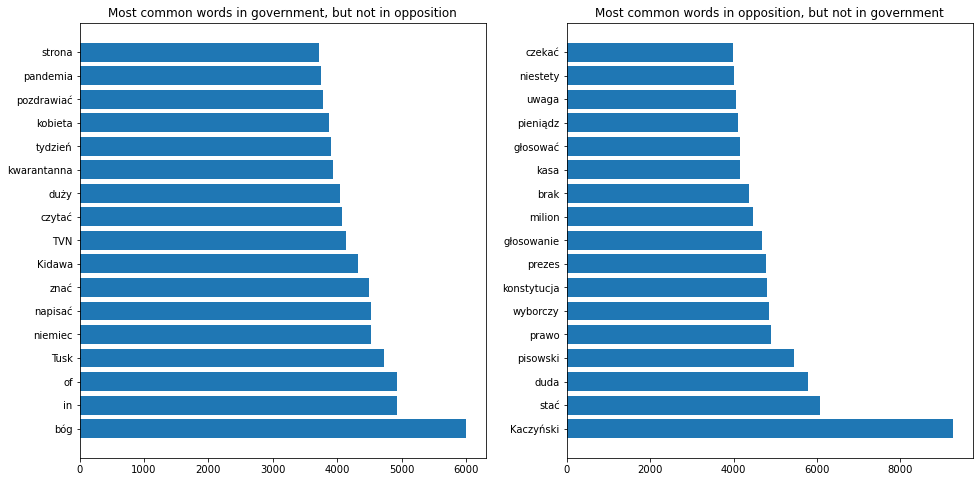

In [4]:
%matplotlib inline
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Most common words in government, but not in opposition")
ax.barh(y = [word[0] for word in gov_words], width = [word[1] for word in gov_words])
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Most common words in opposition, but not in government")
ax.barh(y = [word[0] for word in opp_words], width = [word[1] for word in opp_words])
plt.show()

Tokenize tweets:

In [5]:
tweets = [word_tokenize(tweet) for tweet in tweets]

**Obtain sentence embeddings following steps from the paper [A Simple But Though-to-Beat Baseline for Sentence Embbedings](https://openreview.net/pdf?id=SyK00v5xx)**

Calculate the probabilities of each token:

In [6]:
fdist = FreqDist(itertools.chain.from_iterable(tweets))
a = 10e-3
count = sum(fdist.values())
weights = {k:a/(a + count) for k, v in tqdm(fdist.items())}

Load the word embedding vectors (Glove/fastText):

In [7]:
embed_file = "/home/piotr/nlp/cc.pl.300.vec"
embed = dict()
with open(embed_file, "r") as f:
    for line in tqdm(f):
        elem = line.split()
        if elem[0] in fdist.keys():
            embed[elem[0]] = np.array(elem[1:], dtype = np.float32)

Remove tokens that weren't present in the embeddings dictionary:

In [8]:
for i, tweet in enumerate(tweets):
    tweets[i] = [word for word in tweet if word in embed.keys()]
keep = [i for i in range(len(tweets)) if tweets[i] != []] #keep
tweet_data = tweet_data.iloc[keep] 
tweets = [tweet for tweet in tweets if tweet != []] #delete empty tweets

In [9]:
sentence_embeddings = []
for sentence in tqdm(tweets):
    embedding = np.array([embed[word] for word in sentence])
    weight = np.array([weights[word] for word in sentence])
    res = (embedding.T @ weight)/weight.shape[0]
    sentence_embeddings.append(res)
#bind into one matrix:
sentence_embeddings = np.array(sentence_embeddings).T
del(embed, weights)
gc.collect()

46

Run SVD for the embedding matrix to obtain left singular vectors:

In [10]:
u, _, _ = randomized_svd(sentence_embeddings, 1)

Remove first principal component of the matrix from each column vector:

In [11]:
sentence_embeddings = sentence_embeddings - (u @ u.T @ sentence_embeddings)
sentence_embeddings = sentence_embeddings.T

In [12]:
cluster = MiniBatchKMeans(n_clusters = 8)
cluster.fit(sentence_embeddings)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=8, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Visualize the temporal and between-partisan distribution of the clusters:

In [ ]:
tweet_data["created_at"] = pd.to_datetime(tweet_data["created_at"], format = "%a %b %d %H:%M:%S +0000 %Y")#
tweet_data["created_at"] = tweet_data["created_at"].dt.date

In [14]:
dists = dict()
for i in range(len(np.unique(cluster.labels_))):
    txt = tweet_data.iloc[cluster.labels_ == i].preprocessed.tolist()
    txt = [word_tokenize(word) for word in tqdm(txt)]
    fdist = FreqDist(itertools.chain.from_iterable(txt))
    dists[i] = fdist

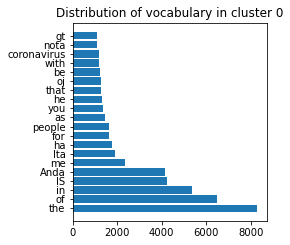

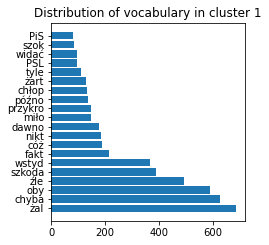

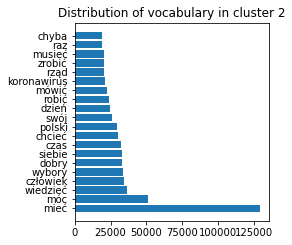

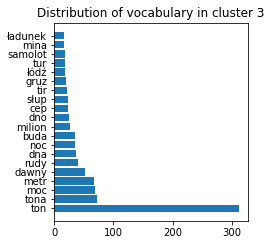

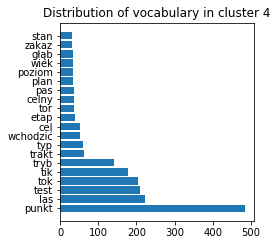

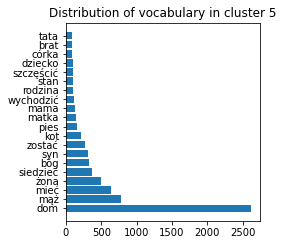

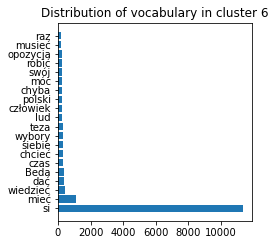

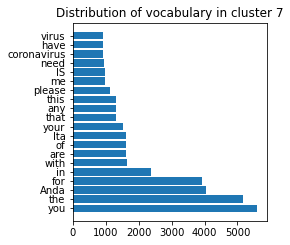

In [16]:
for i, fdist in enumerate(dists.values()):
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title(f"Distribution of vocabulary in cluster {i}")
    ax.barh(y = [word[0] for word in fdist.most_common(20)], width = [word[1] for word in fdist.most_common(20)])
plt.show()

In [ ]:
counts = tweet_data.groupby([cluster.labels_, tweet_data["created_at"], tweet_data["source"]]).count()["id_str"].reset_index()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (16,10))
ax = ax.ravel()
for i in range(len(np.unique(cluster.labels_))):
    ax[i].set_title(f"Cluster number {i}")
    tmp = counts.loc[counts["level_0"] == i]
    #ax[i].set_ylim((0, max(counts.id_str) + int(0.8 * max(counts.id_str))))
    ax[i].bar(tmp[tmp["source"] == "government"]["created_at"], tmp[tmp["source"] == "government"]["id_str"], 
              label = "government")
    ax[i].bar(tmp[tmp["source"] == "opposition"]["created_at"], tmp[tmp["source"] == "opposition"]["id_str"], 
    label = "opposition", bottom = tmp[tmp["source"] == "government"]["id_str"])
    


plt.tight_layout()